In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
# import matplotlib
# matplotlib.use('Agg')
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
from scipy import stats
import itertools
from pprint import pprint

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
# from lazypredict.Supervised import LazyRegressor

/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Makes the Xs and Ys
def break_left_right_and_join(pbif):
    
    # Separate Left and Right brain
    to_drop = ['index', 'Region', 'RegionID']
    
    pbif_left = pbif.loc[(pbif.Region.str.contains(
        "-lh-") | pbif.Region.str.contains("Left-")), :].reset_index().drop(columns=to_drop)
    pbif_right = pbif.loc[(pbif.Region.str.contains(
        "-rh-") | pbif.Region.str.contains("Right-")), :].reset_index().drop(columns=to_drop)
    
    # Rename the columns
    pl = pbif_left.columns
    pbif_left.columns = [str(name)+"_L" for name in pl]
    pr = pbif_right.columns
    pbif_right.columns = [str(name)+"_R" for name in pr]
    
    # Concat those together
    df_pbif = pd.concat((pbif_left,pbif_right), axis=1)
    
    return df_pbif.copy()

In [3]:
# Read new data. Predicted AUC.
xpd = pd.read_excel("/Users/darenma/Downloads/Kinetic_model_PBIF_ML_observedAUC_predictedAUC/Kinetic_model_PBIF_ML_predictedAUC_PD/ATLAS_PD_Regional_Analysis_AIF_vs_PBIF.xlsx", sheet_name="LoganVT-PBIF")
xms = pd.read_excel("/Users/darenma/Downloads/Kinetic_model_PBIF_ML_observedAUC_predictedAUC/Kinetic_model_PBIF_ML_predictedAUC_MS/ATLAS_MS_Regional_Analysis_PBIF.xlsx")

# Make the df for new X from AUC-infered PBIF.
Xnew = pd.concat([xpd, xms.iloc[:, 2:]], axis=1).iloc[1:]

# Rename columns.
Xcols = list(Xnew.columns)
Xcols[0] = "Region"
Xcols[1] = "RegionID"
Xnew.columns = Xcols

# Split l-brain, r-brain & Reshape the df.
df_auc_pbif = break_left_right_and_join(Xnew)

In [159]:
# Display the reshaped df
# df_auc_pbif

## Old Code

In [21]:
# # Read all the data.
# path_ms = "/Users/darenma/Downloads/ATLAS_MS_Regional_Analysis_PBIF.xlsx"
# path_pbif = "/Users/darenma/Downloads/ATLAS_PD_Regional_Analysis_AIF_vs_PBIF.xlsx"
# path_aif = "/Users/darenma/Downloads/ATLAS_PD_Regional_Analysis_AIF_vs_PBIF.xlsx"

# dfms = pd.read_excel(path_ms).iloc[1:]
# pbif = pd.read_excel(path_pbif, sheet_name="LoganVT-PBIF").iloc[1:]
# aif = pd.read_excel(path_aif, sheet_name="LoganVT-AIF").iloc[1:]

# # If missing auc then run this. Else delete.
# auc = pd.read_csv("AUC.csv", index_col=0)


# # Clean the headers of the DataFrames.
# ca = list(aif.columns)
# ca[0] = "Region"
# ca[1] = "RegionID"
# aif.columns = ca

# cp = list(pbif.columns)
# cp[0] = "Region"
# cp[1] = "RegionID"
# pbif.columns = cp

# cm  = list(dfms.columns)
# cm[0] = "Region"
# cm[1] = "RegionID"
# dfms.columns = cm


# df_pbif = break_left_right_and_join(pbif)
# df_aif = break_left_right_and_join(aif)
# df_ms = break_left_right_and_join(dfms)

# df_X = pd.concat((df_pbif, df_ms), axis=1)

# pbif.Region

## Sneha's Code

__(Mainly to get the Y and plot the original scatters)__

In [4]:
input_file = "~/Downloads/ATLAS_PD_MS_ML_Compiled_Features_excelForFormat.csv"

df = pd.read_csv(input_file, encoding='utf-8')

df = df.dropna(subset=['ATLaS_ID'])  # Dropping row with right hemisphere labels
df['ATLaS_ID'] = df['ATLaS_ID'].astype(str)
df['H&Y Stage'] = df['H&Y Stage'].astype('Int32')
df.loc[:, ["Sex", "Genotype"]] = df.loc[:, ["Sex", "Genotype"]].astype("int")  # df.iloc[:, [0, 2, 3, 7]] = df.iloc[:, [0, 2, 3, 7]].astype("int")
# df.loc[:, np.r_["Age", "NET dose (mCi)":"AUC", "ctx-lh-bankssts-PBIF":len(df.columns)]] = df.loc[:, np.r_["Age", "NET dose (mCi)":"AUC", "ctx-lh-bankssts-PBIF":len(df.columns)]].astype('float')   # This does not work as np._ workswith .iloc but not .loc
df.iloc[:, np.r_[1, 4:6, 8:len(df.columns)]] = df.iloc[:, np.r_[1, 4:6, 8:len(df.columns)]].astype('float')
# Scale age, weight, and AUC by a constant. Using this method as we want to leave AIF and PBIF untouched
df.loc[:, 'Age'] = df.loc[:, 'Age']/10
df.loc[:, 'Weight (Kgs)'] = df.loc[:, 'Weight (Kgs)']/10
df.loc[:, 'AUC'] = df.loc[:, 'AUC']/1000
df = df.drop("H&Y Stage", 1)  # Dropping column "H&Y Stage" from the dataframe.
df = df.drop("AUC", 1)  # Dropping column "AUC" from the dataframe
X_end_index = df.columns.get_loc("Left-VentralDC-PBIF") + 1
X = df.loc[:, "Age":"Left-VentralDC-PBIF"]  # X = df.iloc[:, 1:X_end_index]  # X = df.iloc[:, 1:51]
y = df.loc[:, "ctx-lh-bankssts-AIF":]  # y = df.iloc[:, X_end_index:]  # y = df.iloc[:, 51:]

In [5]:
# Plot original VT from PBIF and VT from AIF
PBIF_start_index = df.columns.get_loc("ctx-lh-bankssts-PBIF")
# df.iloc[:, np.r_[1:3, 6:len(df.columns)]]
# df_plot = df.iloc[:, 8:51].copy()
# df_plot = df.loc[:, np.r_[0, "ctx-lh-bankssts-PBIF":"Left-VentralDC-PBIF"]].copy()  # This does not work, as np.r_ works with .iloc but not with .loc
df_plot = df.iloc[:, np.r_[0, PBIF_start_index:X_end_index]].copy()  # df_plot = df.iloc[:, np.r_[0, 8:51]].copy()
# df_plot_long = pd.melt(df_plot.astype(float), id_vars='ATLaS_ID')
df_plot_long = pd.melt(df_plot, id_vars='ATLaS_ID')
df_plot_long.columns = ['ATLaS_ID', 'regions_PBIF', 'VT_PBIF']
df_AIF = y.copy()
df_AIF_long = pd.melt(df_AIF.astype(float))
df_AIF_long.columns = ['regions_AIF', 'VT_AIF']
df_plot_long["regions_AIF"] = df_AIF_long["regions_AIF"]
df_plot_long["VT_AIF"] = df_AIF_long["VT_AIF"].values
df_plot_long["ATLaS_ID"] = df_plot_long["ATLaS_ID"].astype(str)
ATLaS_ID = df_plot_long['ATLaS_ID'].to_numpy()

In [6]:
### Very Important
# I have asserted that the sequence of the regions are the same.
# Rename columns
pbif_col = y.columns
pbif_col = [name[:-3]+"PBIF" for name in pbif_col]

# Demographic columns
# demographic = pd.concat([df.loc[:, "Age":"Genotype"].iloc[0:16], df.loc[:, "Age":"Genotype"].iloc[17:33]])
demographic = df.loc[:, "Age":"Genotype"].reset_index().drop(columns=["index"])

In [7]:
demographic.tail(4)
# print(demographic.shape)

,Age,Sex,NET dose (mCi),Weight (Kgs),Genotype
28,5.8,1,11.2,7.9378,1
29,4.1,1,14.7,8.4823,1
30,3.8,1,16.7,6.3503,2
31,2.7,1,12.7,7.7110,2


12_19_2018(JD)	 
05_08_2019(PP)	
05_22_2019(MM)	
11_01_2017(KT)	
09_26_2017(FR)

In [8]:
print(df.ATLaS_ID[11:16])
print(df_auc_pbif.columns[11:16])

11    FR
12    JD
13    KT
14    MM
15    PP
Name: ATLaS_ID, dtype: object
Index(['DPA092617_L', 'DPA121918_L', 'DPA110117_L', 'DPA052219_L',
       'DPA050819_L'],
      dtype='object')


In [9]:
# Unify the order of rows of X into the sequence that Y already has.
X_transpose = df_auc_pbif.T
X_transpose.columns = pbif_col
tempX = X_transpose.reset_index()
X_transpose = tempX

# Add demographic values.
X_1 = pd.concat((demographic, X_transpose.drop(columns=["index"])), axis=1)

In [10]:
# X_transpose

In [22]:
# Verified with "Ground_Truth.csv" This is the real ground truth.
# y_1 = y.copy()

In [166]:
# Save it so won't need to redo.
X_1.to_csv("AUC-PBIF-X.csv")

In [10]:
gt = pd.read_csv("ground_truth.csv", index_col=0)
y_1 = gt.copy()

## If add noOutlier function

In [55]:
# X_1 = X_1.astype(float)
# y_1 = y_1.astype(float)

In [56]:
# def outlier_treatment(X, y):
#     X_1 = X.copy()
#     y_1 = y.copy()
#     Q1_X = X_1.loc[:, "ctx-lh-bankssts-PBIF":].quantile(0.25)  # Q1_X = X.iloc[:, 7:].quantile(0.25)
#     Q3_X = X_1.loc[:, "ctx-lh-bankssts-PBIF":].quantile(0.75)  # Q3_X = X.iloc[:, 7:].quantile(0.75)
#     IQR_X = Q3_X - Q1_X
#     # if filtering both upper and lower bounds
#     # filter = (X >= Q1 - 1.5 * IQR) & (X <= Q3 + 1.5 *IQR)
#     # if filtering only upper bound
#     filter_X = (X_1.loc[:, "ctx-lh-bankssts-PBIF":] <= Q3_X + 1.5 * IQR_X)  # filter_X = (X.iloc[:, 7:] <= Q3_X + 1.5 * IQR_X)
#     X_1.loc[:, "ctx-lh-bankssts-PBIF":] = X_1.loc[:, "ctx-lh-bankssts-PBIF":].where(filte _X, other=np.nan)  # X.iloc[:, 7:] = X.iloc[:, 7:].where(filter_X, other=np.nan)
#     # Replace the outliers with NAN. In this case we replace any VT values above upper bound with NaN. Once we replace outliers with NaN, we replace those with median
#     X_noOutlier = X_1.fillna(X_1.median())

#     # what does this even mean?
#     Q1_y = y.quantile(0.25)
#     Q3_y = y.quantile(0.75)
#     IQR_y = Q3_y - Q1_y
#     # replacing the very high values with meadians.
#     filter_y = (y <= Q3_y + 1.5 * IQR_y)
#     y = y.where(filter_y, other=np.nan)
#     y_noOutlier = y.fillna(y.median())
    
#     return X_noOutlier, y_noOutlier

In [57]:
# X_noOutlier, y_noOutlier = outlier_treatment(X_1, y_1)

## Plot the scatter

In [11]:
### Make a new long df
atlas_col = np.concatenate((df['ATLaS_ID'].unique(),df['ATLaS_ID'].unique()))
X_1.loc[:,"ATLaS_ID"] = atlas_col
df_long_1 = pd.melt(X_1.drop(columns=["Age", "Sex", 'NET dose (mCi)', 'Weight (Kgs)', 'Genotype']), id_vars='ATLaS_ID')
df_plot_long.loc[:, "VT_PBIF_NEW"] = df_long_1.value.astype(float)
print(df_plot_long.shape)

(1376, 6)


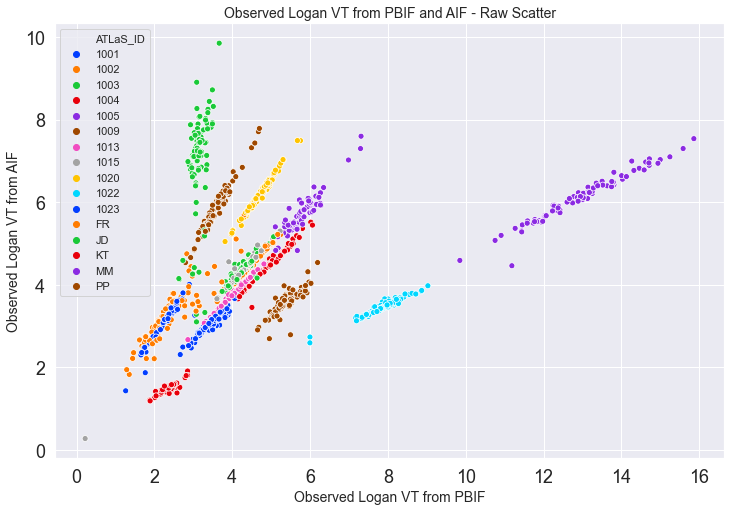

In [14]:
sns.set(rc={"figure.figsize":(12, 8)})

# plot original data --- NEW
sns.scatterplot(data=df_plot_long, x='VT_PBIF', y='VT_AIF', hue="ATLaS_ID", palette="bright")
plt.title('Observed Logan VT from PBIF and AIF - Raw Scatter', fontsize=14)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Observed Logan VT from PBIF', fontsize=14)
# plt.xlim(0, None)
# plt.ylim(0, None)
plt.ylabel('Observed Logan VT from AIF', fontsize=14)
plt.savefig("Original_scatter_plot_Mercy's.png", dpi=600)

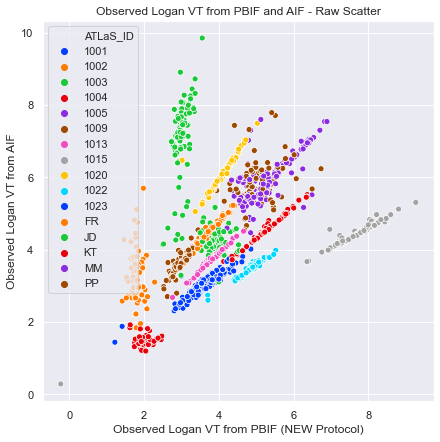

In [40]:
sns.set(rc={"figure.figsize":(7, 7)})

# plot original data --- NEW
sns.scatterplot(data=df_plot_long, x='VT_PBIF_NEW', y='VT_AIF', hue="ATLaS_ID", palette="bright")
plt.title('Observed Logan VT from PBIF and AIF - Raw Scatter')
plt.xlabel('Observed Logan VT from PBIF (NEW Protocol)')
# plt.xlim(0, None)
# plt.ylim(0, None)
plt.ylabel('Observed Logan VT from AIF')
plt.savefig("Original_scatter_plot_new.png")

In [70]:
df_plot_long

,ATLaS_ID,regions_PBIF,VT_PBIF,regions_AIF,VT_AIF,VT_PBIF_NEW
0,1001,ctx-lh-bankssts-PBIF,3.618592,ctx-lh-bankssts-AIF,3.125203,3.632488
1,1002,ctx-lh-bankssts-PBIF,4.198218,ctx-lh-bankssts-AIF,4.177566,3.544963
2,1003,ctx-lh-bankssts-PBIF,2.927057,ctx-lh-bankssts-AIF,6.798339,2.808292
3,1004,ctx-lh-bankssts-PBIF,4.971960,ctx-lh-bankssts-AIF,4.504249,5.226326
4,1005,ctx-lh-bankssts-PBIF,12.967565,ctx-lh-bankssts-AIF,6.187557,5.622179
...,...,...,...,...,...,...
1371,FR,Left-VentralDC-PBIF,1.465100,Left-VentralDC-AIF,2.358200,2.080599
1372,JD,Left-VentralDC-PBIF,4.121210,Left-VentralDC-AIF,4.128987,4.530286
1373,KT,Left-VentralDC-PBIF,2.258635,Left-VentralDC-AIF,1.549575,2.376695
1374,MM,Left-VentralDC-PBIF,6.226527,Left-VentralDC-AIF,6.120247,5.945923


In [ ]:
plt.set_xl

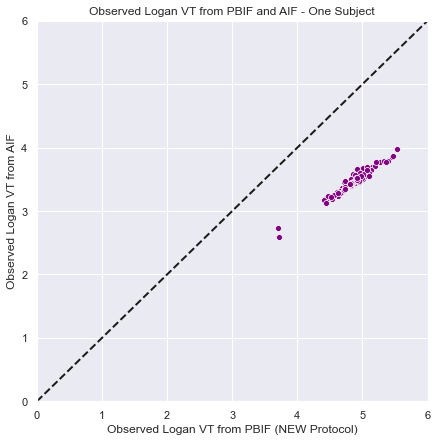

In [102]:
# sns.set(rc={"figure.figsize": (7, 7)})

# plot original data --- NEW
fig = sns.scatterplot(data=df_plot_long.loc[df_plot_long.ATLaS_ID == "1022"],
                x='VT_PBIF_NEW', y='VT_AIF', color="purple")

fig.set_xlim(0, 6)
fig.set_ylim(0, 6)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False,
         scaley=False,)
plt.title('Observed Logan VT from PBIF and AIF - One Subject')
plt.xlabel('Observed Logan VT from PBIF (NEW Protocol)')
plt.ylabel('Observed Logan VT from AIF')
plt.savefig("Theta_Showcase.png")


# plot original data --- OLD
# sns.scatterplot(data=df_plot_long, x='VT_PBIF', y='VT_AIF', hue="ATLaS_ID", palette="bright", ci=None)
# plt.title('Observed Logan VT from PBIF and AIF - Raw Scatter')
# plt.xlabel('Observed Logan VT from PBIF')
# plt.ylabel('Observed Logan VT from AIF')
# plt.show()
# # plt.savefig("Original_scatter_plot.png")

## Traditional Machine Learning Part

In [41]:
from varname import nameof
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [42]:
# Helper Function for metric reporting.
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    # print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Average Error: {:0.4f} degrees.'.format(errors.mean()))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy

In [43]:
def run_gbr_model(X, y, docstring=""):
# GradientBoostingRegressor
    y_true_base, y_pred_base = list(), list()
    mae_errs_base = list()
    cv = LeaveOneOut()
    y_true, y_pred = list(), list()
    mae_errs = list()

    fig = plt.figure()
    # set palette
    palette = itertools.cycle(sns.color_palette())

    for train_index, test_index in cv.split(X):
#         print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        gbr = GradientBoostingRegressor(
                                random_state=42, 
                                min_samples_leaf=2, 
                                n_estimators=400, 
                                max_features=20, 
                                max_leaf_nodes=4,
                                min_samples_split=2,
                                learning_rate=0.05,
        )
        model_gbr = MultiOutputRegressor(gbr)
        # Look at parameters used by our current forest
    #     print('Parameters currently in use:\n')
    #     pprint(model_gbr.estimator.get_params())
        # Base model evaluation: Fit the regressor with x and y data
        model_gbr.fit(X_train.values, y_train.values)  # use this if age, weight, and auc are scaled by a constant
        base_model_accuracy = evaluate(model_gbr, X_test.to_numpy(), y_test.to_numpy())

        yhat = model_gbr.predict(X_test)

        # store
        y_true_base.append(y_test.to_numpy())
        y_pred_base.append(yhat)

        print('MAE:', mean_absolute_error(y_test, yhat))
        mae_errs_base.append(mean_absolute_error(y_test, yhat))

        c = next(palette)
        # sns.regplot(x=y_test, y=yhat, scatter_kws={"color": "red"}, line_kws={"color": "black"})
    #     sns.set(rc={"figure.figsize":(7, 7)})
        sns.regplot(x=yhat.reshape(-1), y=np.array(y_test).reshape(-1), color=c, ci=None)
        fig.legend(df['ATLaS_ID'].unique())
        plt.title('Multi output GBR - individual regression lines')
        plt.ylabel('Observed Logan VT (from AIF)')
        plt.xlabel('Predicted Logan VT')
        plt.axis('equal')
        plt.savefig(f"GBR-Lineplot{docstring}.png")
        

    fig = plt.figure()
    sns.set(rc={"figure.figsize":(7, 7)})
    sns.regplot(x=np.vstack(y_pred_base).flatten(), y=np.vstack(y_true_base).flatten(), scatter=False)
    sns.scatterplot(x=np.vstack(y_pred_base).flatten(), y=np.vstack(y_true_base).flatten(), hue=ATLaS_ID, palette="bright", legend="full")
    slope_p, intercept_p, r_value_p, p_value_p, std_err_p = stats.linregress(np.vstack(y_true_base).flatten(), np.vstack(y_pred_base).flatten())
    plt.title('Multi output GBR - common regression lines')
    plt.ylabel('Observed Logan VT (from AIF)')
    plt.xlabel('Predicted Logan VT')
    plt.axis('equal')
    plt.savefig(f"GBR-Scatter{docstring}.png")
    
    print('Pearson correlation R and p-val are: ', r_value_p.round(5), ',', p_value_p)

    return model_gbr, mae_errs_base

In [44]:
X_1

,Age,Sex,NET dose (mCi),Weight (Kgs),Genotype,ctx-lh-bankssts-PBIF,ctx-lh-caudalanteriorcingulate-PBIF,ctx-lh-caudalmiddlefrontal-PBIF,ctx-lh-cuneus-PBIF,ctx-lh-entorhinal-PBIF,...,Left-Cerebellum-Cortex-PBIF,Left-Thalamus-Proper-PBIF,Left-Caudate-PBIF,Left-Putamen-PBIF,Left-Pallidum-PBIF,Left-Hippocampus-PBIF,Left-Amygdala-PBIF,Left-Accumbens-area-PBIF,Left-VentralDC-PBIF,ATLaS_ID
0,6.8,1,16.09,8.164663,2,3.6324879349741344,1.4159289668782669,3.8163955152590723,3.4516653647442226,3.605662558707466,...,3.037230150971008,4.217773533706054,3.219375336039259,3.7031746916821895,3.9435316000515193,3.257306018400372,3.70829749550451,3.542627304760122,3.4108632225939326,1001
1,5.9,1,14.36,8.164663,2,3.544963042626802,3.4366952296039646,4.085936018628823,3.524335293221062,3.7090434723513854,...,3.606134402726629,4.341158574890913,3.0477200035162806,3.84464649214763,4.29766567862768,4.081181765586464,4.145661954235095,4.258617776514827,4.100849952717053,1002
2,6.3,1,12.86,8.164663,1,2.8082923155781554,2.960673512329223,3.559234942619077,2.8430115851983015,3.2248352276438665,...,2.9186650333070503,3.324473847730472,2.5240742643264387,2.995738188010375,3.1585914652166682,2.9693577852454736,2.982846370464612,2.8990554233478516,3.369071325356741,1003
3,7.1,1,13.37,6.577089,2,5.226325566031106,3.5657476191303745,5.385030972324097,5.168610293594847,4.65268118970341,...,5.035243364891556,6.005680861820095,4.744755638941973,5.489440717207214,5.7944759066130285,4.9498113802562225,5.219776372681166,5.338987412879893,5.200915977185247,1004
4,6.2,1,13.50,5.624545,2,5.62217857604926,5.843585619864315,5.699768760329078,5.616886387220216,5.183578412558404,...,5.118433842677624,6.831845465987757,4.22119900703003,6.028585271578329,5.951823400174181,6.068301110316347,6.203743155204982,6.256918199843024,6.8946693178402,1005
5,5.5,0,11.15,5.533827,1,2.7297079825643795,2.6427518453446917,2.896563418992755,3.021519161703551,2.6614250495033525,...,3.16636321067676,3.208452911936668,2.5339343768951093,3.20265265019483,2.954567930829229,2.973462686563335,2.9853825411101327,2.77355632231848,3.1133478003231385,1009
6,6.8,1,15.49,7.711070,1,4.085379303830161,3.2283435217546503,4.292754811517269,3.5906768843578227,4.095063577959019,...,3.5232421043165356,4.378662450677573,2.763854251911487,4.05781896691116,4.29452871964454,3.9343830601220495,4.267054667978496,3.836152489985111,4.328243959608234,1013
7,6.8,1,12.65,8.164663,2,7.43888606987627,-0.2266216549838172,8.131915478215356,7.471184897410422,7.638208237683502,...,6.7557724299523425,8.79732212389821,6.408171576237206,8.221519996241575,8.60146289670192,7.797279218802372,7.295864343003805,7.31542387823343,8.155415420466072,1015
8,6.5,0,16.69,6.894604,2,4.247475244489662,3.5643599619027735,4.299816569144671,3.946141731795666,4.088842804687084,...,4.112270930407342,5.0400859642123095,3.545766037610737,4.277690932827294,4.520225736719391,4.0855680353312875,4.318981185805084,4.350720148781605,4.723516796549165,1020
9,6.1,0,14.69,5.624545,2,4.932008961671759,4.437657762648289,4.95255912957521,4.901881127857257,4.475598708170477,...,4.511496155293695,5.449509992974868,3.7047211289768778,4.824191108922902,5.1041976994107054,4.9745299442313735,4.813189807635837,4.735257491503848,5.524612434304997,1022


In [45]:
32 * 0.812500

26.0

In [46]:
# X_1 = X_1.astype(float)
# X_1 = X_1.drop(columns=['ATLaS_ID']).astype(float)
X_1.fillna(X_1.median())
# y_1 = y_1.astype(float)

,Age,Sex,NET dose (mCi),Weight (Kgs),Genotype,ctx-lh-bankssts-PBIF,ctx-lh-caudalanteriorcingulate-PBIF,ctx-lh-caudalmiddlefrontal-PBIF,ctx-lh-cuneus-PBIF,ctx-lh-entorhinal-PBIF,...,Left-Cerebellum-Cortex-PBIF,Left-Thalamus-Proper-PBIF,Left-Caudate-PBIF,Left-Putamen-PBIF,Left-Pallidum-PBIF,Left-Hippocampus-PBIF,Left-Amygdala-PBIF,Left-Accumbens-area-PBIF,Left-VentralDC-PBIF,ATLaS_ID
0,6.8,1,16.09,8.164663,2,3.6324879349741344,1.4159289668782669,3.8163955152590723,3.4516653647442226,3.605662558707466,...,3.037230150971008,4.217773533706054,3.219375336039259,3.7031746916821895,3.9435316000515193,3.257306018400372,3.70829749550451,3.542627304760122,3.4108632225939326,1001
1,5.9,1,14.36,8.164663,2,3.544963042626802,3.4366952296039646,4.085936018628823,3.524335293221062,3.7090434723513854,...,3.606134402726629,4.341158574890913,3.0477200035162806,3.84464649214763,4.29766567862768,4.081181765586464,4.145661954235095,4.258617776514827,4.100849952717053,1002
2,6.3,1,12.86,8.164663,1,2.8082923155781554,2.960673512329223,3.559234942619077,2.8430115851983015,3.2248352276438665,...,2.9186650333070503,3.324473847730472,2.5240742643264387,2.995738188010375,3.1585914652166682,2.9693577852454736,2.982846370464612,2.8990554233478516,3.369071325356741,1003
3,7.1,1,13.37,6.577089,2,5.226325566031106,3.5657476191303745,5.385030972324097,5.168610293594847,4.65268118970341,...,5.035243364891556,6.005680861820095,4.744755638941973,5.489440717207214,5.7944759066130285,4.9498113802562225,5.219776372681166,5.338987412879893,5.200915977185247,1004
4,6.2,1,13.50,5.624545,2,5.62217857604926,5.843585619864315,5.699768760329078,5.616886387220216,5.183578412558404,...,5.118433842677624,6.831845465987757,4.22119900703003,6.028585271578329,5.951823400174181,6.068301110316347,6.203743155204982,6.256918199843024,6.8946693178402,1005
5,5.5,0,11.15,5.533827,1,2.7297079825643795,2.6427518453446917,2.896563418992755,3.021519161703551,2.6614250495033525,...,3.16636321067676,3.208452911936668,2.5339343768951093,3.20265265019483,2.954567930829229,2.973462686563335,2.9853825411101327,2.77355632231848,3.1133478003231385,1009
6,6.8,1,15.49,7.711070,1,4.085379303830161,3.2283435217546503,4.292754811517269,3.5906768843578227,4.095063577959019,...,3.5232421043165356,4.378662450677573,2.763854251911487,4.05781896691116,4.29452871964454,3.9343830601220495,4.267054667978496,3.836152489985111,4.328243959608234,1013
7,6.8,1,12.65,8.164663,2,7.43888606987627,-0.2266216549838172,8.131915478215356,7.471184897410422,7.638208237683502,...,6.7557724299523425,8.79732212389821,6.408171576237206,8.221519996241575,8.60146289670192,7.797279218802372,7.295864343003805,7.31542387823343,8.155415420466072,1015
8,6.5,0,16.69,6.894604,2,4.247475244489662,3.5643599619027735,4.299816569144671,3.946141731795666,4.088842804687084,...,4.112270930407342,5.0400859642123095,3.545766037610737,4.277690932827294,4.520225736719391,4.0855680353312875,4.318981185805084,4.350720148781605,4.723516796549165,1020
9,6.1,0,14.69,5.624545,2,4.932008961671759,4.437657762648289,4.95255912957521,4.901881127857257,4.475598708170477,...,4.511496155293695,5.449509992974868,3.7047211289768778,4.824191108922902,5.1041976994107054,4.9745299442313735,4.813189807635837,4.735257491503848,5.524612434304997,1022


In [49]:
X_1 = X_1.drop(columns="ATLaS_ID")

Model Performance
Average Error: 0.3555 degrees.
Accuracy = 87.17%.
MAE: 0.3555448673153239
Model Performance
Average Error: 0.2534 degrees.
Accuracy = 94.52%.
MAE: 0.25335467921428784
Model Performance
Average Error: 1.2560 degrees.
Accuracy = 80.12%.
MAE: 1.2560240216375547
Model Performance
Average Error: 0.5006 degrees.
Accuracy = 88.28%.
MAE: 0.5006220628630552
Model Performance
Average Error: 0.8640 degrees.
Accuracy = 86.36%.
MAE: 0.8640032201226698
Model Performance
Average Error: 0.4809 degrees.
Accuracy = 86.13%.
MAE: 0.480880599877686
Model Performance
Average Error: 0.1841 degrees.
Accuracy = 94.90%.
MAE: 0.18409845349549425
Model Performance
Average Error: 0.7768 degrees.
Accuracy = 54.59%.
MAE: 0.7768241191296135
Model Performance
Average Error: 1.0499 degrees.
Accuracy = 83.04%.
MAE: 1.049866653474056
Model Performance
Average Error: 0.6855 degrees.
Accuracy = 79.90%.
MAE: 0.6855117510228214
Model Performance
Average Error: 0.5107 degrees.
Accuracy = 82.45%.
MAE: 0.51067

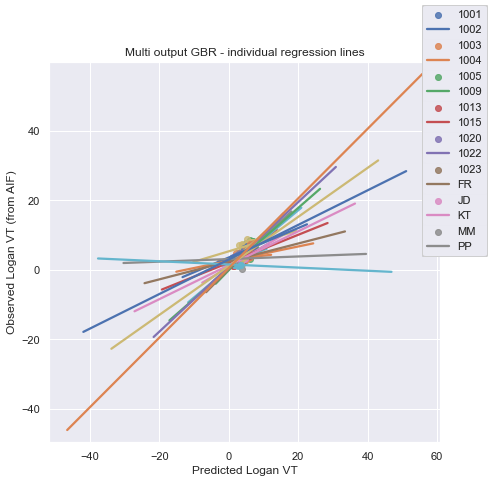

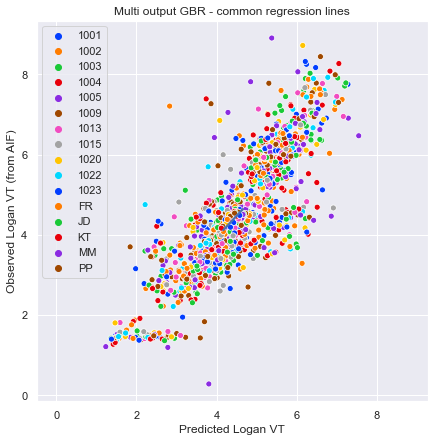

In [50]:
gbr_usual, err_usual = run_gbr_model(X_1, y_1, docstring="paper1204")

In [51]:
np.mean(err_usual)

0.593829311424735

In [52]:
gbr_usual.score(X_1, y_1)

0.9947386079385702

In [53]:
y_pred = gbr_usual.predict(X_1)

In [54]:
y_1

,ctx-lh-bankssts-AIF,ctx-lh-caudalanteriorcingulate-AIF,ctx-lh-caudalmiddlefrontal-AIF,ctx-lh-cuneus-AIF,ctx-lh-entorhinal-AIF,ctx-lh-fusiform-AIF,ctx-lh-inferiorparietal-AIF,ctx-lh-inferiortemporal-AIF,ctx-lh-isthmuscingulate-AIF,ctx-lh-lateraloccipital-AIF,...,ctx-lh-insula-AIF,Left-Cerebellum-Cortex-AIF,Left-Thalamus-Proper-AIF,Left-Caudate-AIF,Left-Putamen-AIF,Left-Pallidum-AIF,Left-Hippocampus-AIF,Left-Amygdala-AIF,Left-Accumbens-area-AIF,Left-VentralDC-AIF
0,3.125203,1.873116,3.026488,3.066844,3.117090,2.923615,2.975958,3.122835,2.604903,2.839497,...,3.209057,2.587755,3.670306,2.812893,3.187369,3.422196,2.850343,3.241260,3.100149,2.966440
1,4.177566,4.001726,4.797934,4.164397,4.404920,4.265981,4.123583,4.351055,3.672082,4.109379,...,4.594383,4.345024,5.209784,3.596146,4.612134,5.019328,4.869401,4.947333,5.024508,4.938094
2,6.798339,5.996654,4.172483,7.130261,6.909646,7.484297,7.894639,4.012902,6.468731,7.783759,...,7.495862,7.624260,7.926448,4.152393,7.126104,6.356390,7.245702,6.820607,6.396845,8.321740
3,4.504249,3.067001,4.623479,4.423945,3.999827,4.201309,4.800641,4.350727,3.406117,4.762298,...,4.318038,4.310324,5.148324,4.081895,4.706808,4.981016,4.260664,4.490494,4.552298,4.457660
4,6.187557,6.397762,6.246417,6.091463,5.645087,5.452820,6.030841,5.903451,5.548808,5.810986,...,5.863077,5.538975,7.541340,4.591923,6.558390,6.503927,6.644773,6.771543,6.782976,7.540600
5,3.251689,3.640094,3.488588,3.808203,3.165270,3.782511,3.503088,3.300699,3.734807,3.694768,...,3.626466,3.841946,3.807341,2.908689,3.878036,3.476682,3.536618,3.554233,3.246256,3.748539
6,3.937230,3.113986,4.146916,3.596803,3.956943,3.778832,3.820019,3.876286,3.280671,3.552171,...,4.066538,3.433611,4.306378,2.673897,3.945309,4.160017,3.795996,4.146565,3.736848,4.180387
7,4.247210,0.279044,4.653723,4.311167,4.511180,4.116990,4.243420,4.198694,2.485102,4.224036,...,4.610748,3.928322,5.112683,3.682667,4.965569,4.965923,4.469742,4.320746,4.235368,4.656267
8,6.226713,5.323264,6.406424,5.894871,6.063891,5.986334,6.012579,6.134036,5.308826,5.998421,...,6.241297,6.101625,7.492272,5.233588,6.376922,6.718285,6.087326,6.414141,6.469192,7.033518
9,3.476571,3.206528,3.656379,3.491500,3.206734,3.476944,3.397419,3.320784,3.167962,3.480909,...,3.517425,3.215705,3.846272,2.736822,3.438013,3.597879,3.553311,3.427199,3.354274,3.978442


In [55]:
y_pred

array([[3.12148175, 1.87533674, 3.02615153, ..., 3.23879077, 3.09791414,
        2.96292379],
       [4.18019323, 4.01206646, 4.80466418, ..., 4.94701705, 5.02209521,
        4.9370391 ],
       [6.79373777, 5.98005379, 4.18684896, ..., 6.80875031, 6.40087027,
        8.29893428],
       ...,
       [1.42893417, 1.49616626, 1.50055059, ..., 1.58575091, 1.47390665,
        1.5419393 ],
       [5.63839524, 6.15002344, 5.37842694, ..., 5.81324464, 5.82077194,
        6.12161394],
       [4.44762293, 5.03136387, 5.69608086, ..., 5.72030632, 6.16607148,
        5.8517869 ]])

In [56]:
for i in range(32):
    print(r2_score(y_1.iloc[i], y_pred[i]))

0.999932426144879
0.9998737163962923
0.9998948808058803
0.9999954278923439
0.9992427523168187
0.9999638230894905
0.9998931739475301
0.9999464739406663
0.998338068741234
0.9945814481562798
0.9999085172577706
0.9998520557910697
0.9998712667641878
0.9988836801416655
0.999994810918268
0.9999762660629015
0.9988456729650781
0.999749149553537
0.9998028496920824
0.9999927716085909
0.9999668305699472
0.9999285053056179
0.9998719084070778
0.9971453729778019
0.9997370377933812
0.9986587062872917
0.9998928021933171
0.999784912870269
0.9998725810980299
0.9965932785485557
0.9999846705981048
-0.17379861945765462


In [145]:
### Compared with last time.

d_errors = {"RF":0.8037655032564262, 
     "MLP":1.188977379209999, 
     "SVR":1.7285567113975324, 
     "Ridge":1.5126799416196555, 
     "GBR":0.5405199737381606}

### Theta - Transformation Model

In [57]:
y_1

,ctx-lh-bankssts-AIF,ctx-lh-caudalanteriorcingulate-AIF,ctx-lh-caudalmiddlefrontal-AIF,ctx-lh-cuneus-AIF,ctx-lh-entorhinal-AIF,ctx-lh-fusiform-AIF,ctx-lh-inferiorparietal-AIF,ctx-lh-inferiortemporal-AIF,ctx-lh-isthmuscingulate-AIF,ctx-lh-lateraloccipital-AIF,...,ctx-lh-insula-AIF,Left-Cerebellum-Cortex-AIF,Left-Thalamus-Proper-AIF,Left-Caudate-AIF,Left-Putamen-AIF,Left-Pallidum-AIF,Left-Hippocampus-AIF,Left-Amygdala-AIF,Left-Accumbens-area-AIF,Left-VentralDC-AIF
0,3.125203,1.873116,3.026488,3.066844,3.117090,2.923615,2.975958,3.122835,2.604903,2.839497,...,3.209057,2.587755,3.670306,2.812893,3.187369,3.422196,2.850343,3.241260,3.100149,2.966440
1,4.177566,4.001726,4.797934,4.164397,4.404920,4.265981,4.123583,4.351055,3.672082,4.109379,...,4.594383,4.345024,5.209784,3.596146,4.612134,5.019328,4.869401,4.947333,5.024508,4.938094
2,6.798339,5.996654,4.172483,7.130261,6.909646,7.484297,7.894639,4.012902,6.468731,7.783759,...,7.495862,7.624260,7.926448,4.152393,7.126104,6.356390,7.245702,6.820607,6.396845,8.321740
3,4.504249,3.067001,4.623479,4.423945,3.999827,4.201309,4.800641,4.350727,3.406117,4.762298,...,4.318038,4.310324,5.148324,4.081895,4.706808,4.981016,4.260664,4.490494,4.552298,4.457660
4,6.187557,6.397762,6.246417,6.091463,5.645087,5.452820,6.030841,5.903451,5.548808,5.810986,...,5.863077,5.538975,7.541340,4.591923,6.558390,6.503927,6.644773,6.771543,6.782976,7.540600
5,3.251689,3.640094,3.488588,3.808203,3.165270,3.782511,3.503088,3.300699,3.734807,3.694768,...,3.626466,3.841946,3.807341,2.908689,3.878036,3.476682,3.536618,3.554233,3.246256,3.748539
6,3.937230,3.113986,4.146916,3.596803,3.956943,3.778832,3.820019,3.876286,3.280671,3.552171,...,4.066538,3.433611,4.306378,2.673897,3.945309,4.160017,3.795996,4.146565,3.736848,4.180387
7,4.247210,0.279044,4.653723,4.311167,4.511180,4.116990,4.243420,4.198694,2.485102,4.224036,...,4.610748,3.928322,5.112683,3.682667,4.965569,4.965923,4.469742,4.320746,4.235368,4.656267
8,6.226713,5.323264,6.406424,5.894871,6.063891,5.986334,6.012579,6.134036,5.308826,5.998421,...,6.241297,6.101625,7.492272,5.233588,6.376922,6.718285,6.087326,6.414141,6.469192,7.033518
9,3.476571,3.206528,3.656379,3.491500,3.206734,3.476944,3.397419,3.320784,3.167962,3.480909,...,3.517425,3.215705,3.846272,2.736822,3.438013,3.597879,3.553311,3.427199,3.354274,3.978442


In [58]:
Xnew

,Region,RegionID,1001-PBIF,1002-PBIF,1003-PBIF,1004-PBIF,1005-PBIF,1009-PBIF,1013-PBIF,1015-PBIF,1020-PBIF,1022-PBIF,1023-PBIF,DPA092617,DPA121918,DPA110117,DPA052219,DPA050819
1,ctx-lh-bankssts,3001_o,3.6324879349741344,3.544963042626802,2.8082923155781554,5.226325566031106,5.62217857604926,2.7297079825643795,4.085379303830161,7.43888606987627,4.247475244489662,4.932008961671759,3.6814572381090143,1.814821545923822,4.086718682659952,1.943274029362426,4.826755777144109,4.743871619772317
2,ctx-lh-caudalanteriorcingulate,3002_o,1.4159289668782669,3.4366952296039646,2.960673512329223,3.5657476191303745,5.843585619864315,2.6427518453446917,3.2283435217546503,-0.2266216549838172,3.5643599619027735,4.437657762648289,3.3634925219196576,1.5389710987782006,3.783374096727684,1.7669539147562534,4.867106600105095,4.147410010080876
3,ctx-lh-caudalmiddlefrontal,3003_o,3.8163955152590723,4.085936018628823,3.559234942619077,5.385030972324097,5.699768760329078,2.896563418992755,4.292754811517269,8.131915478215356,4.299816569144671,4.95255912957521,3.6845690194983933,1.8062259557497107,3.9121086808144616,1.9118410210440668,5.105420799759548,4.693544221060317
4,ctx-lh-cuneus,3005_o,3.4516653647442226,3.524335293221062,2.8430115851983015,5.168610293594847,5.616886387220216,3.021519161703551,3.5906768843578227,7.471184897410422,3.946141731795666,4.901881127857257,3.6381821208043696,1.8037464860806205,3.7773365522567364,1.9121048383990331,4.818622410018125,5.38916686768349
5,ctx-lh-entorhinal,3006_o,3.605662558707466,3.7090434723513854,3.2248352276438665,4.65268118970341,5.183578412558404,2.6614250495033525,4.095063577959019,7.638208237683502,4.088842804687084,4.475598708170477,3.3589742484982557,1.7799987289608574,3.8070750557171165,1.770003542884062,4.411065286588673,4.7489819317604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,Right-Pallidum,52_o,3.8326320973477905,4.14049174703528,3.063695953902351,5.615767194158813,6.4566079722457035,3.1924232432944923,4.663813326657502,9.270936555524823,4.682708021551221,5.094371495323405,4.369536896792036,1.8822372819427664,4.0222918577393925,2.17195472325799,5.3036553917209535,6.7360487333934005
83,Right-Hippocampus,53_o,3.2696781561650745,3.7191357118509756,3.0395864157706893,4.637000847689918,5.544819965641955,2.992159329009761,3.775536394824491,7.593696519236088,4.235839855463066,5.070003719914657,3.9126760167929104,1.8189391169369498,4.134466004289613,2.116948430111672,5.202846450597207,5.4176719432558675
84,Right-Amygdala,54_o,3.787583427332463,4.026634399937811,2.9817904708680913,4.352881318005746,6.088550213101186,2.991875121458383,4.014767305863642,7.884951856134261,3.021884906067967,4.913226921221878,3.8269314204327487,1.6609334745774467,4.436653419107833,1.87986150621291,5.191896496144298,5.5812165206303606
85,Right-Accumbens-area,58_o,3.5965447010185287,3.989891953074879,3.217129185409225,4.359092382415353,6.410443984661694,2.9654628862167822,4.060794082421637,8.33791528969735,4.21874773797332,4.910365725349525,4.400562066370317,1.7856572980257912,3.7532179090779825,1.9297920043305576,5.520462455043025,5.340895385032188


In [59]:
subjs = df_plot_long.ATLaS_ID.unique()
theta_dict = {}
xmean_dict = {}
ymean_dict = {}
for subj in subjs:
    df_by_subj = df_plot_long.loc[df_plot_long.ATLaS_ID == subj]
    x_mean = df_by_subj.VT_PBIF_NEW.mean()
    y_mean = df_by_subj.VT_AIF.mean()
    tan_theta = y_mean/x_mean
    theta_dict[subj] = tan_theta
    xmean_dict[subj] = x_mean
    ymean_dict[subj] = y_mean

In [60]:
y_theta_form = pd.DataFrame(theta_dict.values())

In [61]:
x_theta_form = Xnew.T.iloc[2:].copy().reset_index().drop(columns=['index'])
x_theta_form.columns = Xnew.T.iloc[0]

In [62]:
demographic[:16].shape

(16, 5)

In [63]:
x_theta_form = pd.concat((x_theta_form, demographic[:16], pd.DataFrame(xmean_dict.values()) ), axis=1)

In [111]:
model_theta = GradientBoostingRegressor(random_state=42, 
                        min_samples_leaf=2, 
                        n_estimators=400, 
                        max_features=5, 
                        max_leaf_nodes=4,
                        min_samples_split=2,
                        learning_rate=0.05,
                               )
# Look at parameters used by our current forest
#     print('Parameters currently in use:\n')
#     pprint(model_gbr.estimator.get_params())
# Base model evaluation: Fit the regressor with x and y data

# use this if age, weight, and auc are scaled by a constant
model_theta.fit(x_theta_form.values, y_theta_form.values)  
base_model_accuracy = evaluate(model_theta, x_theta_form.to_numpy(), y_theta_form.to_numpy())

yhat_theta = model_theta.predict(x_theta_form.values)

Model Performance
Average Error: 0.4472 degrees.
Accuracy = 58.56%.


In [115]:
GradientBoostingRegressor?

In [118]:
X_1

,Age,Sex,NET dose (mCi),Weight (Kgs),Genotype,ctx-lh-bankssts-PBIF,ctx-lh-caudalanteriorcingulate-PBIF,ctx-lh-caudalmiddlefrontal-PBIF,ctx-lh-cuneus-PBIF,ctx-lh-entorhinal-PBIF,...,ctx-lh-insula-PBIF,Left-Cerebellum-Cortex-PBIF,Left-Thalamus-Proper-PBIF,Left-Caudate-PBIF,Left-Putamen-PBIF,Left-Pallidum-PBIF,Left-Hippocampus-PBIF,Left-Amygdala-PBIF,Left-Accumbens-area-PBIF,Left-VentralDC-PBIF
0,6.8,1,16.09,8.164663,2,3.6324879349741344,1.4159289668782669,3.8163955152590723,3.4516653647442226,3.605662558707466,...,3.9537418513666793,3.037230150971008,4.217773533706054,3.219375336039259,3.7031746916821895,3.9435316000515193,3.257306018400372,3.70829749550451,3.542627304760122,3.4108632225939326
1,5.9,1,14.36,8.164663,2,3.544963042626802,3.4366952296039646,4.085936018628823,3.524335293221062,3.7090434723513854,...,3.934055629952584,3.606134402726629,4.341158574890913,3.0477200035162806,3.84464649214763,4.29766567862768,4.081181765586464,4.145661954235095,4.258617776514827,4.100849952717053
2,6.3,1,12.86,8.164663,1,2.8082923155781554,2.960673512329223,3.559234942619077,2.8430115851983015,3.2248352276438665,...,3.092167681219141,2.9186650333070503,3.324473847730472,2.5240742643264387,2.995738188010375,3.1585914652166682,2.9693577852454736,2.982846370464612,2.8990554233478516,3.369071325356741
3,7.1,1,13.37,6.577089,2,5.226325566031106,3.5657476191303745,5.385030972324097,5.168610293594847,4.65268118970341,...,5.023147347396644,5.035243364891556,6.005680861820095,4.744755638941973,5.489440717207214,5.7944759066130285,4.9498113802562225,5.219776372681166,5.338987412879893,5.200915977185247
4,6.2,1,13.50,5.624545,2,5.62217857604926,5.843585619864315,5.699768760329078,5.616886387220216,5.183578412558404,...,5.356567897104169,5.118433842677624,6.831845465987757,4.22119900703003,6.028585271578329,5.951823400174181,6.068301110316347,6.203743155204982,6.256918199843024,6.8946693178402
5,5.5,0,11.15,5.533827,1,2.7297079825643795,2.6427518453446917,2.896563418992755,3.021519161703551,2.6614250495033525,...,2.906201456399579,3.16636321067676,3.208452911936668,2.5339343768951093,3.20265265019483,2.954567930829229,2.973462686563335,2.9853825411101327,2.77355632231848,3.1133478003231385
6,6.8,1,15.49,7.711070,1,4.085379303830161,3.2283435217546503,4.292754811517269,3.5906768843578227,4.095063577959019,...,4.216913355114033,3.5232421043165356,4.378662450677573,2.763854251911487,4.05781896691116,4.29452871964454,3.9343830601220495,4.267054667978496,3.836152489985111,4.328243959608234
7,6.8,1,12.65,8.164663,2,7.43888606987627,-0.2266216549838172,8.131915478215356,7.471184897410422,7.638208237683502,...,7.948463148009904,6.7557724299523425,8.79732212389821,6.408171576237206,8.221519996241575,8.60146289670192,7.797279218802372,7.295864343003805,7.31542387823343,8.155415420466072
8,6.5,0,16.69,6.894604,2,4.247475244489662,3.5643599619027735,4.299816569144671,3.946141731795666,4.088842804687084,...,4.20408028328393,4.112270930407342,5.0400859642123095,3.545766037610737,4.277690932827294,4.520225736719391,4.0855680353312875,4.318981185805084,4.350720148781605,4.723516796549165
9,6.1,0,14.69,5.624545,2,4.932008961671759,4.437657762648289,4.95255912957521,4.901881127857257,4.475598708170477,...,4.908433839872439,4.511496155293695,5.449509992974868,3.7047211289768778,4.824191108922902,5.1041976994107054,4.9745299442313735,4.813189807635837,4.735257491503848,5.524612434304997


In [113]:
model_theta = GradientBoostingRegressor(random_state=42, 
                        min_samples_leaf=2,
                        max_depth =2,                
                        n_estimators=400, 
                        max_features=5, 
                        max_leaf_nodes=4,
                        min_samples_split=2,
                        learning_rate=0.05,
                               )
# Look at parameters used by our current forest
#     print('Parameters currently in use:\n')
#     pprint(model_gbr.estimator.get_params())
# Base model evaluation: Fit the regressor with x and y data

# use this if age, weight, and auc are scaled by a constant
model_theta.fit(x_theta_form.values, y_theta_form.values)  
base_model_accuracy = evaluate(model_theta, x_theta_form.to_numpy(), y_theta_form.to_numpy())

yhat_theta = model_theta.predict(x_theta_form.values)

Model Performance
Average Error: 0.4457 degrees.
Accuracy = 58.70%.


In [119]:
y_theta_form

,0
0,0.863415
1,1.190080
2,2.353379
3,0.862030
4,1.094752
5,1.216940
6,0.974141
7,0.579007
8,1.488882
9,0.713968


In [66]:
yhat_theta

array([0.86481175, 1.19030567, 2.35212903, 0.86151355, 1.09118627,
       1.21578553, 0.97338085, 0.58108781, 1.48594755, 0.71820017,
       0.81066893, 1.8223235 , 1.11157024, 0.73843165, 1.14266538,
       1.15321615])

In [67]:
subjs = df_plot_long.ATLaS_ID.unique()

for i, subj in enumerate(subjs):
    df_by_subj = df_plot_long.loc[df_plot_long.ATLaS_ID == subj]
    theta_hat = yhat_theta[i]
    df_by_subj.loc[:, "VT_PRED_THETA"] = df_by_subj["VT_PBIF_NEW"]*theta_hat
    if i == 0:
        df_plot_long_with_theta = df_by_subj.copy()
    else:
        df_plot_long_with_theta = pd.concat((df_plot_long_with_theta, df_by_subj.copy()), axis=0)

In [68]:
df_plot_long_with_theta

,ATLaS_ID,regions_PBIF,VT_PBIF,regions_AIF,VT_AIF,VT_PBIF_NEW,VT_PRED_THETA
0,1001,ctx-lh-bankssts-PBIF,3.618592,ctx-lh-bankssts-AIF,3.125203,3.632488,3.141418
16,1001,ctx-lh-bankssts-PBIF,3.251344,ctx-lh-bankssts-AIF,2.927193,3.354556,2.901059
32,1001,ctx-lh-caudalanteriorcingulate-PBIF,1.764931,ctx-lh-caudalanteriorcingulate-AIF,1.873116,1.415929,1.224512
48,1001,ctx-lh-caudalanteriorcingulate-PBIF,2.663417,ctx-lh-caudalanteriorcingulate-AIF,2.312698,2.799238,2.420814
64,1001,ctx-lh-caudalmiddlefrontal-PBIF,3.675814,ctx-lh-caudalmiddlefrontal-AIF,3.026488,3.816396,3.300464
...,...,...,...,...,...,...,...
1311,PP,Left-Amygdala-PBIF,3.830682,Left-Amygdala-AIF,6.278149,5.581217,6.436349
1327,PP,Left-Accumbens-area-PBIF,4.258944,Left-Accumbens-area-AIF,6.845310,5.776103,6.661095
1343,PP,Left-Accumbens-area-PBIF,3.937894,Left-Accumbens-area-AIF,6.252835,5.340895,6.159207
1359,PP,Left-VentralDC-PBIF,4.091883,Left-VentralDC-AIF,6.621300,6.017672,6.939677


Text(0, 0.5, 'Observed Logan VT from AIF')

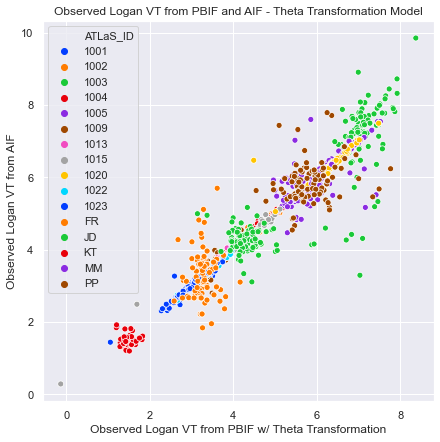

In [69]:
sns.set(rc={"figure.figsize":(7, 7)})
# plot original data --- NEW
sns.scatterplot(data=df_plot_long_with_theta, x='VT_PRED_THETA', y='VT_AIF', hue="ATLaS_ID", palette="bright")
plt.title('Observed Logan VT from PBIF and AIF - Theta Transformation Model')
plt.xlabel('Observed Logan VT from PBIF w/ Theta Transformation')
# plt.xlim(0, None)
# plt.ylim(0, None)
plt.ylabel('Observed Logan VT from AIF')
# plt.show()
# plt.savefig("Theta_Transformation_Model_new.png")

In [ ]:
sns.set(rc={"figure.figsize":(7, 7)})
# plot original data --- NEW
sns.scatterplot(data=df_plot_long_with_theta, x='VT_PRED_THETA', y='VT_AIF', hue="ATLaS_ID", palette="bright")
plt.title('Observed Logan VT from PBIF and AIF - Theta Transformation Model')
plt.xlabel('Observed Logan VT from PBIF w/ Theta Transformation')
# plt.xlim(0, None)
# plt.ylim(0, None)
plt.ylabel('Observed Logan VT from AIF')

In [104]:
# from sklearn.metrics import mean_absolute_error
df_plot_long_with_theta.VT_AIF

mean_absolute_error(df_plot_long_with_theta.VT_AIF, df_plot_long_with_theta.VT_PRED_THETA)

0.1973437205854999

In [108]:
df_pd_theta = df_plot_long_with_theta.loc[df_plot_long_with_theta.ATLaS_ID.str.startswith(
    "1")]
df_ms_theta = df_plot_long_with_theta.loc[~df_plot_long_with_theta.ATLaS_ID.str.startswith(
    "1")]


In [109]:
mean_absolute_error(df_pd_theta.VT_AIF, df_pd_theta.VT_PRED_THETA)

0.1117103927298772

In [110]:
mean_absolute_error(df_ms_theta.VT_AIF, df_ms_theta.VT_PRED_THETA)

0.3857370418678699

## So far the conclusions

In [152]:
def run_diag_model(X, y):
# GradientBoostingRegressor
    y_true_base, y_pred_base = list(), list()
    mae_errs_base = list()
    cv = LeaveOneOut()
    y_true, y_pred = list(), list()
    mae_errs = list()

    fig = plt.figure()
    # set palette
    palette = itertools.cycle(sns.color_palette())

    for train_index, test_index in cv.split(X):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        gbr = GradientBoostingRegressor(random_state=42, 
                                min_samples_leaf=2, 
                                n_estimators=400, 
                                max_features=20, 
                                max_leaf_nodes=4,
                                min_samples_split=2,
                                learning_rate=0.05,
                                       )
        model_gbr = MultiOutputRegressor(gbr)
        # Look at parameters used by our current forest
    #     print('Parameters currently in use:\n')
    #     pprint(model_gbr.estimator.get_params())
        # Base model evaluation: Fit the regressor with x and y data
        
        # use this if age, weight, and auc are scaled by a constant
        model_gbr.fit(X_train.values, y_train.values)  
        base_model_accuracy = evaluate(model_gbr, X_test.to_numpy(), y_test.to_numpy())

        yhat = model_gbr.predict(X_test)

        # store
        y_true_base.append(y_test.to_numpy())
        y_pred_base.append(yhat)

        print('Mean Absolute Error of base model:', mean_absolute_error(y_test, yhat))
        mae_errs_base.append(mean_absolute_error(y_test, yhat))

        c = next(palette)
        # sns.regplot(x=y_test, y=yhat, scatter_kws={"color": "red"}, line_kws={"color": "black"})
    #     sns.set(rc={"figure.figsize":(7, 7)})
        sns.regplot(x=np.array(y_test).reshape(-1), y=yhat.reshape(-1), color=c, ci=None)
        fig.legend(df['ATLaS_ID'].unique())
        plt.title('Multi output GBR - individual regression lines')
        plt.xlabel('Observed Logan VT (from AIF)')
        plt.ylabel('Predicted Logan VT')
        plt.axis('equal')
        plt.savefig("GBR-lineplot.png")

    fig = plt.figure()
    # sns.set(rc={"figure.figsize":(7, 7)})
    sns.regplot(x=np.vstack(y_true_base).flatten(), y=np.vstack(y_pred_base).flatten(), scatter=False)
    sns.scatterplot(x=np.vstack(y_true_base).flatten(), y=np.vstack(y_pred_base).flatten(), hue=ATLaS_ID, palette="bright", legend="full")
    slope_p, intercept_p, r_value_p, p_value_p, std_err_p = stats.linregress(np.vstack(y_true_base).flatten(), np.vstack(y_pred_base).flatten())
    plt.title('Multi output GBR - common regression lines')
    plt.xlabel('Observed Logan VT (from AIF)')
    plt.ylabel('Predicted Logan VT')
    plt.axis('equal')
    plt.savefig("GBR-Scatter.png")
    print('Pearson correlation R and p-val are: ', r_value_p.round(5), ',', p_value_p)

    print('debug')
    
    return model_gbr, mae_errs_base

In [151]:
GradientBoostingRegressor?

TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [0]
Model Performance
Average Error: 1.3358 degrees.
Accuracy = 53.97%.
Mean Absolute Error of base model: 1.335756848756837
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [1]
Model Performance
Average Error: 0.8312 degrees.
Accuracy = 80.82%.
Mean Absolute Error of base model: 0.8312261293801833
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [2]
Model Performance
Average Error: 3.2198 degrees.
Accuracy = 55.61%.
Mean Absolute Error of base model: 3.2198009180179086
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [3]
Model Performance
Average Error: 0.8961 degrees.
Accuracy = 79.66%.
Mean Absolute Error of base model: 0.8961013534713187
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18

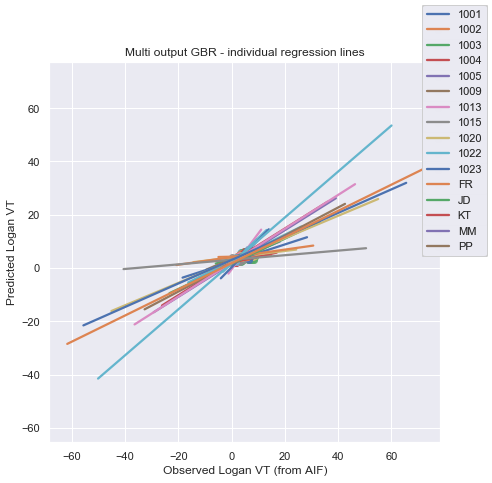

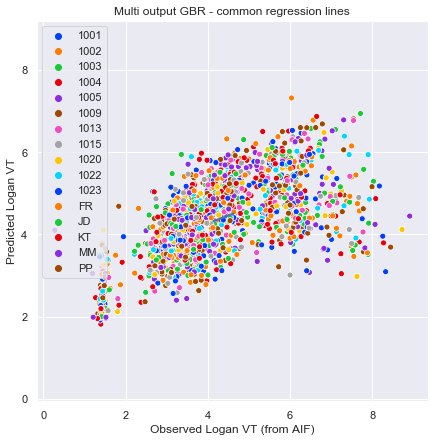

In [153]:
model_d, err_d = run_diag_model(X_noOutlier, y_noOutlier)

In [154]:
np.mean(err_d)

0.9374516194626071

## Predict AUC using Demographic

### GLM models for it

In [137]:
from sklearn.preprocessing import PolynomialFeatures
import sklearn.linear_model as linear_model
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import numpy as np

In [72]:
Xauc = demographic.astype(float).reset_index().drop(columns=["index"])
yauc = auc.T.auc.reset_index().drop(columns=["index"])

In [74]:
yauc

,auc
0,1056.187543
1,1001.383012
2,551.894369
3,936.386926
4,1422.840034
5,1137.344202
6,1013.737449
7,681.179977
8,641.376154
9,1635.262077


In [131]:
test_index = [4,5,6,11,12,16,17,26,27,28]
badXauc = Xauc.index.isin(test_index)
Xauc_train = Xauc[~badXauc]
Xauc_test = Xauc.iloc[test_index]
yauc_train = yauc[~badXauc]
yauc_test = yauc.iloc[test_index]

In [139]:
gbr = GradientBoostingRegressor(random_state=42, 
                                min_samples_leaf=1, 
                                n_estimators=200, 
                                max_features=3, 
                                max_leaf_nodes=2,
                                learning_rate=0.1,
                                validation_fraction=0.2,
                                n_iter_no_change=55,
                                       )

In [140]:
gbr.fit(Xauc_train, yauc_train)

GradientBoostingRegressor(max_features=3, max_leaf_nodes=2, n_estimators=200,
                          n_iter_no_change=55, random_state=42,
                          validation_fraction=0.2)

In [142]:
gbr.score(Xauc_train, yauc_train), gbr.score(Xauc_test, yauc_test)

(0.9845524096741944, -3.298070876964979)

In [145]:
gbr.predict(Xauc)

array([ 788.78581313, 1146.78284343,  575.23699732,  957.27564757,
       1435.6772105 , 1165.67760281,  917.22541875,  683.59226105,
        697.92924918, 1582.91610005,  565.56917623, 1264.23299958,
       1038.26304329,  892.04258242, 1342.64995154, 1274.78664475,
        788.78581313, 1146.78284343,  575.23699732,  957.27564757,
       1435.6772105 , 1165.67760281,  917.22541875,  683.59226105,
        697.92924918, 1582.91610005,  565.56917623, 1264.23299958,
       1038.26304329,  892.04258242, 1342.64995154, 1274.78664475])

In [143]:
gbr.score(Xauc, yauc)

0.6628618575954239

In [181]:

glm_model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])
# fit to an order-3 polynomial data

glm_model = glm_model.fit(Xauc_train, yauc_train)
glm_model.named_steps['linear'].coef_


array([[  20.9196564 ,   35.06317047,  -57.33931546,  261.89538949,
          28.98947919,   71.25094736,   70.5869491 , -252.41975166,
          28.6523318 , -149.054736  ,   82.24407135,  -57.33931546,
          35.71083938,  279.27586059, -133.49715286,   67.8790273 ,
        -257.1201934 , -292.22533078,  214.64879828,  343.85711767,
         171.91352928]])

## READ THE DATA

In [123]:
aif_simple = pd.read_csv("AIF_Simple_Data.csv", index_col=0)

new_df = aif_simple.drop(columns=["ID"]).astype(np.float).copy()
new_df.loc[:,"sqrt_dose"] = np.sqrt(new_df[["NET dose (mCi)"]])
new_df.loc[:,"lambda"] = new_df['sqrt_dose'].div(new_df['Weight (Kgs)'])
new_df["dose_by_age"] = new_df['NET dose (mCi)']/new_df['Age']
new_df["weight_by_age"] = new_df['Weight (Kgs)']/new_df["Age"]
new_df.Sex = 2*(new_df.Sex-0.5)
new_df.Genotype = (new_df.Genotype-1.5)*2
new_df["asg"] = new_df.Age * new_df.Sex * new_df.Genotype

new_df["dose_2"] = new_df['NET dose (mCi)']**2
new_df["weight_2"] = new_df['Weight (Kgs)']**2
new_df["sqrt_weight"] = new_df['Weight (Kgs)']**0.5
new_df["lambda_0.5"] = new_df['lambda'] ** 0.5
new_df["weight_-1"] = new_df['Weight (Kgs)']**(-1)

In [124]:
new_df = aif_simple.drop(columns=["ID"]).astype(np.float).copy()
new_df.loc[:,"sqrt_dose"] = np.sqrt(new_df[["NET dose (mCi)"]])
new_df.loc[:,"lambda"] = new_df['sqrt_dose'].div(new_df['Weight (Kgs)'])
new_df["dose_by_age"] = new_df['NET dose (mCi)']/new_df['Age']
new_df["weight_by_age"] = new_df['Weight (Kgs)']/new_df["Age"]
new_df.Sex = 2*(new_df.Sex-0.5)
new_df.Genotype = (new_df.Genotype-1.5)*2
new_df["asg"] = new_df.Age * new_df.Sex * new_df.Genotype

In [125]:
new_df["dose_2"] = new_df['NET dose (mCi)']**2
new_df["weight_2"] = new_df['Weight (Kgs)']**2
new_df["sqrt_weight"] = new_df['Weight (Kgs)']**0.5
new_df["lambda_0.5"] = new_df['lambda'] ** 0.5
new_df["weight_-1"] = new_df['Weight (Kgs)']**(-1)

In [126]:
new_df

,Age,Sex,NET dose (mCi),Weight (Kgs),Genotype,auc,sqrt_dose,lambda,dose_by_age,weight_by_age,asg,dose_2,weight_2,sqrt_weight,lambda_0.5,weight_-1
0,6.8,1.0,16.09,8.164663,1.0,1056.187543,4.011234,0.491292,2.366176,1.200686,6.8,258.8881,66.661716,2.857387,0.700922,0.122479
1,5.9,1.0,14.36,8.164663,1.0,1001.383012,3.789459,0.464129,2.433898,1.383841,5.9,206.2096,66.661716,2.857387,0.681270,0.122479
2,6.3,1.0,12.86,8.164663,-1.0,551.894369,3.586084,0.439220,2.041270,1.295978,-6.3,165.3796,66.661716,2.857387,0.662737,0.122479
3,7.1,1.0,13.37,6.577089,1.0,936.386926,3.656501,0.555945,1.883099,0.926351,7.1,178.7569,43.258105,2.564584,0.745617,0.152043
4,6.2,1.0,13.50,5.624545,1.0,1422.840034,3.674235,0.653250,2.177419,0.907185,6.2,182.2500,31.635511,2.371612,0.808239,0.177792
5,5.5,-1.0,11.15,5.533827,-1.0,1137.344202,3.339162,0.603409,2.027273,1.006150,5.5,124.3225,30.623240,2.352409,0.776794,0.180707
6,6.8,1.0,15.49,7.711070,-1.0,1013.737449,3.935734,0.510400,2.277941,1.133981,-6.8,239.9401,59.460605,2.776881,0.714423,0.129684
7,6.8,1.0,12.65,8.164663,1.0,681.179977,3.556684,0.435619,1.860294,1.200686,6.8,160.0225,66.661716,2.857387,0.660015,0.122479
8,6.5,-1.0,16.69,6.894604,1.0,641.376154,4.085340,0.592542,2.567692,1.060708,-6.5,278.5561,47.535565,2.625758,0.769767,0.145041
9,6.1,-1.0,14.69,5.624545,1.0,1635.262077,3.832754,0.681433,2.408197,0.922057,-6.1,215.7961,31.635511,2.371612,0.825490,0.177792


In [132]:
new_target = pd.read_csv("Interpolate_1207_slinear.csv")
# Original One
# new_target = pd.read_csv("Interpolate_0901.csv")

In [133]:
new_target

,Unnamed: 0,tts,1001,1002,1003,1004,1005,1009,1013,1015,1020,1022,1023,FR,JD,KT,MM,PP
0,0,0,0.0,0.000000,0.000000e+00,13.200000,3.0,0.000000,0.0,0.0,14.0,0.000000,0.0,0.000000,0.000000,0.750000,0.000000,0.000557
1,1,15,0.0,0.000000,0.000000e+00,17.600000,16.0,0.000000,0.0,0.0,21.0,0.000000,0.0,10.500000,0.000000,1.000000,0.000000,0.000352
2,2,30,0.0,0.000000,9.000000e+00,22.000000,27.0,19.000000,0.0,0.0,21.0,0.000000,9.0,21.000000,1.000000,19.000000,0.000000,1.000000
3,3,45,31.0,34.000000,2.800000e+01,31.000000,35.0,46.000000,18.0,15.0,21.0,60.000000,44.0,31.500000,21.000000,33.000000,6.000000,23.000000
4,4,60,59.0,49.000000,4.100000e+01,33.000000,39.0,49.000000,55.0,45.0,23.0,81.000000,59.0,42.000000,48.000000,46.000000,36.000000,34.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,356,5340,1.0,0.022222,4.021990e-08,0.005618,1.0,0.022222,1.0,1.0,1.0,1.022346,1.0,1.034483,0.033613,2.005587,0.033898,0.033333
357,357,5355,1.0,0.016667,3.016495e-08,0.000000,1.0,0.016667,1.0,1.0,1.0,1.016760,1.0,1.025862,0.025210,2.000000,0.025424,0.025000
358,358,5370,1.0,0.011111,2.011001e-08,0.000000,1.0,0.011111,1.0,1.0,1.0,1.011173,1.0,1.017241,0.016807,0.000000,0.016949,0.016667
359,359,5385,1.0,0.005556,1.005507e-08,0.000000,1.0,0.005556,1.0,1.0,1.0,1.005587,1.0,1.008621,0.008403,0.000000,0.008475,0.008333


In [134]:
new_y = np.array(new_target.sum().T[2:])

In [135]:
new_y

array([1089.5       ,  871.5       ,  436.00025803,  824.8       ,
       1212.5       ,  828.5       , 1028.        ,  847.        ,
        790.        , 1612.        ,  880.        , 1693.5       ,
        860.5       , 1525.75      ,  720.5       ,  701.500909  ])

In [138]:
# Make Parameters List
paralist = [
    #'NET dose (mCi), '
    'Weight (Kgs)',
    'asg',
    'lambda',
    'dose_by_age',
    'weight_by_age',
]
Y_s = new_df.auc
X_s = new_df[paralist]
X_s = sm.add_constant(X_s)
model_s = sm.OLS(new_y, X_s)
results_s = model_s.fit()
results_s.params 

const           -3275.370580
Weight (Kgs)      194.966005
asg                -3.406729
lambda           5436.208150
dose_by_age      -398.436460
weight_by_age     758.038932
dtype: float64

In [139]:
results_s.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                 -0.317
Method:                 Least Squares   F-statistic:                    0.2781
Date:                Wed, 07 Dec 2022   Prob (F-statistic):              0.915
Time:                        14:34:15   Log-Likelihood:                -114.92
No. Observations:                  16   AIC:                             241.8
Df Residuals:                      10   BIC:                             246.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3275.3706   4126.114     -0.794      0.446   -1.25e+04    5918.185
Weight (Kgs)    194.9660    223.179      0.874      0.403    -302.307     692.239
asg              -3.4067     17.701     -0.192      0.851     -42.848      36.034
lambda         5436.2082   5056.820      1.075      0.308   -5831.089    1.67e+04
dose_by_age    -398.4365    518.064     -0.769      0.460   -1552.755     755.882
weight_by_age   758.0389    971.661      0.780      0.453   -1406.956    2923.034
==============================================================================
Omnibus:                        4.398   Durbin-Watson:                   2.382
Prob(Omnibus):                  0.111   Jarque-Bera (JB):                2.417
Skew:                           0.937   Prob(JB):                        0.299
Kurtosis:                       3.342   Cond. No.                         549.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [285]:
# Make Parameters List
paralist = [
    #'NET dose (mCi), '
    'Weight (Kgs)',
    'asg',
    'lambda',
    'dose_by_age',
    'weight_by_age',
]
Y_s = new_df.auc
X_s = new_df[paralist]
X_s = sm.add_constant(X_s)
model_s = sm.OLS(Y_s,X_s)
results_s = model_s.fit()
results_s.params 

const           -4608.481646
Weight (Kgs)      194.216095
asg                13.410592
lambda           7437.777462
dose_by_age      -417.991738
weight_by_age    1015.996546
dtype: float64

In [286]:
results_s.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    auc   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     5.858
Date:                Mon, 29 Aug 2022   Prob (F-statistic):            0.00877
Time:                        13:30:43   Log-Likelihood:                -102.70
No. Observations:                  16   AIC:                             217.4
Df Residuals:                      10   BIC:                             222.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4608.4816   1922.447     -2.397      0.037   -8891.961    -325.002
Weight (Kgs)    194.2161    103.984      1.868      0.091     -37.474     425.907
asg              13.4106      8.247      1.626      0.135      -4.966      31.787
lambda         7437.7775   2356.083      3.157      0.010    2188.096    1.27e+04
dose_by_age    -417.9917    241.377     -1.732      0.114    -955.814     119.831
weight_by_age  1015.9965    452.718      2.244      0.049       7.278    2024.715
==============================================================================
Omnibus:                        6.846   Durbin-Watson:                   2.525
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                3.754
Skew:                          -0.897   Prob(JB):                        0.153
Kurtosis:                       4.554   Cond. No.                         549.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [421]:
### BEST SO FAR -- SAVE THIS MODEL
paralist = [
#     'NET dose (mCi)', 
#     'Weight (Kgs)',
#     "weight_-1",
    'Age',
#     "Sex",

#     "Genotype",
    'lambda',
#     'dose_by_age',
#     'weight_by_age',
#     "asg"
]
Y_s = new_df.auc
X_s = new_df[paralist]
X_s = sm.add_constant(X_s)
model_s = sm.OLS(Y_s,X_s)
results_s = model_s.fit()
# results_s.params 
results_s.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    auc   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     7.042
Date:                Mon, 29 Aug 2022   Prob (F-statistic):            0.00847
Time:                        14:48:24   Log-Likelihood:                -107.78
No. Observations:                  16   AIC:                             221.6
Df Residuals:                      13   BIC:                             223.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        438.4459    415.473      1.055      0.311    -459.128    1336.020
Age          -82.2866     46.715     -1.761      0.102    -183.207      18.634
lambda      2039.2381    612.705      3.328      0.005     715.569    3362.907
==============================================================================
Omnibus:                        0.890   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.641   Jarque-Bera (JB):                0.433
Skew:                          -0.395   Prob(JB):                        0.806
Kurtosis:                       2.841   Cond. No.                         73.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [356]:
y_pred = results_s.fittedvalues

In [359]:
y_pred.T

0      944.884133
1      881.388458
2      653.877069
3     1099.386199
4     1566.771255
5     1081.230123
6      856.223773
7      723.499460
8      948.722643
9     1384.029667
10     992.818128
11     947.183817
12     599.574325
13     963.549135
14    1336.910636
15    1299.298328
dtype: float64

In [358]:
list(y_pred)

[944.8841330931173,
 881.3884579619552,
 653.8770686948321,
 1099.3861991053482,
 1566.7712547669184,
 1081.230123066699,
 856.2237729755398,
 723.4994596691538,
 948.7226430037991,
 1384.0296669994839,
 992.8181278970771,
 947.1838173404785,
 599.574324914666,
 963.5491349334812,
 1336.9106359311395,
 1299.298327986209]

In [328]:
# Best so far
paralist = [
    #'NET dose (mCi), '
#     'Weight (Kgs)',
#     'Age',
#     "lambda_0.5",
    "Sex",
#     "Genotype",
    'lambda',
    'sqrt_weight',
#     'sqrt_dose',
#     'dose_by_age',
    'weight_by_age',
#     "dose_2",
#     "weight_2",
#     "asg"
]
Y_s = new_df.auc
X_s = new_df[paralist]
X_s = sm.add_constant(X_s)
model_s = sm.OLS(Y_s,X_s)
results_s = model_s.fit()
# results_s.params 
results_s.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    auc   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     4.138
Date:                Mon, 29 Aug 2022   Prob (F-statistic):             0.0276
Time:                        13:52:25   Log-Likelihood:                -106.30
No. Observations:                  16   AIC:                             222.6
Df Residuals:                      11   BIC:                             226.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2652.4304   2499.163     -1.061      0.311   -8153.052    2848.191
Sex              66.3543     89.315      0.743      0.473    -130.227     262.935
lambda         4039.7025   1669.945      2.419      0.034     364.179    7715.226
sqrt_weight     444.0329    623.463      0.712      0.491    -928.199    1816.265
weight_by_age   241.8000    129.781      1.863      0.089     -43.845     527.445
==============================================================================
Omnibus:                        2.458   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.293   Jarque-Bera (JB):                1.063
Skew:                          -0.618   Prob(JB):                        0.588
Kurtosis:                       3.263   Cond. No.                         182.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## SAVE THE FILES FOR SNEHA

In [577]:
mainf = pd.read_excel("/Users/darenma/Downloads/AIF/PBIF0827.xlsx",
                      sheet_name="subject-wise-PBIF", index_col=0, header=1)

In [578]:
mainf = mainf.reset_index()

In [579]:
mainf

,index,Dec_19_2019(JD),May_8_2019(PP),May_22_2019(MM),Nov_1_2017(KT),Sept_26_2017(FR),1001,1002,1003,1004,1005,1009,1013,1015,1020,1022,1023
0,NaN,0.597486,0.426486,0.663483,0.776736,0.575129,0.559687,0.406610,0.551119,0.915316,0.740973,0.591464,0.422019,0.521655,0.797260,0.308779,0.575129
1,NaN,0.698077,0.498288,0.775186,0.907505,0.671956,0.653915,0.475065,0.643904,1.069416,0.865722,0.691041,0.493069,0.609479,0.931485,0.360764,0.671956
2,NaN,0.798668,0.570090,0.886888,1.038275,0.768784,0.748142,0.543521,0.736690,1.223517,0.990470,0.790619,0.564119,0.697304,1.065710,0.412749,0.768784
3,NaN,0.899260,0.641892,0.998591,1.169044,0.865611,0.842370,0.611977,0.829475,1.377617,1.115219,0.890196,0.635169,0.785128,1.199935,0.464735,0.865611
4,NaN,0.999851,0.713695,1.110293,1.299813,0.962438,0.936598,0.680433,0.922260,1.531718,1.239967,0.989774,0.706220,0.872953,1.334160,0.516720,0.962438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5396,NaN,0.041861,0.029880,0.046485,0.054420,0.040295,0.039213,0.028488,0.038612,0.064129,0.051914,0.041439,0.029567,0.036548,0.055858,0.021634,0.040295
5397,NaN,0.041844,0.029868,0.046466,0.054397,0.040278,0.039196,0.028476,0.038596,0.064102,0.051892,0.041422,0.029555,0.036533,0.055834,0.021625,0.040278
5398,NaN,0.041826,0.029855,0.046446,0.054374,0.040261,0.039180,0.028464,0.038580,0.064075,0.051871,0.041404,0.029543,0.036518,0.055811,0.021616,0.040261
5399,NaN,0.041809,0.029843,0.046427,0.054351,0.040244,0.039164,0.028452,0.038564,0.064049,0.051849,0.041387,0.029530,0.036502,0.055788,0.021607,0.040244


#### MS subjects

In [580]:
PATH_MS = "/Users/darenma/Downloads/PBIFs_replace_and_compare/PBIF_sqrtDose_weight_scale_ML_MS/"
df_DPA050819 = pd.read_csv(PATH_MS+"popbased_MetCorrWB_sqrt_dose_weight_ML_DPA050819.crv",sep="\t", index_col=0)
df_DPA052219 = pd.read_csv(PATH_MS+"popbased_MetCorrWB_sqrt_dose_weight_ML_DPA052219.crv",sep="\t", index_col=0)
df_DPA092617 = pd.read_csv(PATH_MS+"popbased_MetCorrWB_sqrt_dose_weight_ML_DPA092617.crv",sep="\t", index_col=0)
df_DPA110117 = pd.read_csv(PATH_MS+"popbased_MetCorrWB_sqrt_dose_weight_ML_DPA110117.crv",sep="\t", index_col=0)
df_DPA121918 = pd.read_csv(PATH_MS+"popbased_MetCorrWB_sqrt_dose_weight_ML_DPA121918.crv",sep="\t", index_col=0)

In [581]:
df_DPA050819.loc[:,'value[kBq/cc]'] = mainf["May_8_2019(PP)"]
df_DPA052219.loc[:,'value[kBq/cc]'] = mainf["May_22_2019(MM)"]
df_DPA092617.loc[:,'value[kBq/cc]'] = mainf["Sept_26_2017(FR)"]
df_DPA110117.loc[:,'value[kBq/cc]'] = mainf["Nov_1_2017(KT)"]
df_DPA121918.loc[:,'value[kBq/cc]'] = mainf["Dec_19_2019(JD)"]

In [582]:
df_DPA050819.to_csv(PATH_MS+"popbased_MetCorrWB_sqrt_dose_weight_ML_DPA050819.crv",sep="\t", index=False)
df_DPA052219.to_csv(PATH_MS+"popbased_MetCorrWB_sqrt_dose_weight_ML_DPA052219.crv",sep="\t", index=False)
df_DPA092617.to_csv(PATH_MS+"popbased_MetCorrWB_sqrt_dose_weight_ML_DPA092617.crv",sep="\t", index=False)
df_DPA110117.to_csv(PATH_MS+"popbased_MetCorrWB_sqrt_dose_weight_ML_DPA110117.crv",sep="\t", index=False)
df_DPA121918.to_csv(PATH_MS+"popbased_MetCorrWB_sqrt_dose_weight_ML_DPA121918.crv",sep="\t", index=False)

#### PD subjects

In [583]:
PATH_PD = '/Users/darenma/Downloads/PBIFs_replace_and_compare/PBIF_sqrtDose_weight_scale_ML_PD/popbased_MetCorrWB_sqrt_dose_weight_ML_'

In [584]:
[str(t) for t in mainf.columns]

['index',
 'Dec_19_2019(JD)',
 'May_8_2019(PP)',
 'May_22_2019(MM)',
 'Nov_1_2017(KT)',
 'Sept_26_2017(FR)',
 '1001',
 '1002',
 '1003',
 '1004',
 '1005',
 '1009',
 '1013',
 '1015',
 '1020',
 '1022',
 '1023']

In [585]:
zl = ['1001',
 '1002',
 '1003',
 '1004',
 '1005',
 '1009',
 '10013',
 '10015',
 '10020',
 '10022',
 '10023']

In [586]:
for x in zl:
    if len(x)>4:
        xname = int(x[0]+x[2:])
    else:
        xname = int(x)
    pathn = PATH_PD + x + ".crv"
    dfn = pd.read_csv(pathn, sep="\t")
    dfn.loc[:,'value[kBq/cc]'] = mainf[xname]
    dfn.to_csv(pathn, sep="\t", index=False)

In [587]:
pathn = PATH_PD + x + ".crv"

In [588]:
dfn = pd.read_csv(pathn, sep="\t")

In [589]:
dfn

,Parent_input_curve_model_time[seconds],value[kBq/cc]
0,0,0.575129
1,1,0.671956
2,2,0.768784
3,3,0.865611
4,4,0.962438
...,...,...
5396,5396,0.040295
5397,5397,0.040278
5398,5398,0.040261
5399,5399,0.040244


## Leave-One-Out Linear Models

In [140]:
point_labels = aif_simple.ID

In [141]:
new_y

array([1089.5       ,  871.5       ,  436.00025803,  824.8       ,
       1212.5       ,  828.5       , 1028.        ,  847.        ,
        790.        , 1612.        ,  880.        , 1693.5       ,
        860.5       , 1525.75      ,  720.5       ,  701.500909  ])

In [142]:
Y_s

0     1056.187543
1     1001.383012
2      551.894369
3      936.386926
4     1422.840034
5     1137.344202
6     1013.737449
7      681.179977
8      641.376154
9     1635.262077
10     979.403275
11    1048.822219
12     667.934656
13     853.812634
14    1362.838398
15    1288.944225
Name: auc, dtype: float64

In [143]:
def lou_model(new_df, paralist=["Age", "lambda"], mode="linear", annotations = aif_simple.ID):
# GradientBoostingRegressor
    y_true_base, y_pred_base = list(), list()
    mae_errs_base = list()
    cv = LeaveOneOut()
    print("Leave-One-Out model predicting ...")
    y_true, y_pred = list(), list()
    mae_errs = list()
    y = new_df.auc
    X = new_df[paralist]
    
    if mode == "linear":
        X = sm.add_constant(X)
    
    for train_index, test_index in cv.split(X):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if mode == "linear":
            model_s = sm.OLS(y_train, X_train)
            results_s = model_s.fit()
            X_test = sm.add_constant(X_test)
            results_s.summary()
            yhat = results_s.predict(X_test)
        
        elif mode == "gbr":
            gbr = GradientBoostingRegressor(random_state=42, 
                                min_samples_leaf=2, 
                                n_estimators=400, 
                                max_features=1, 
                                max_leaf_nodes=4,
                                min_samples_split=2,
                                learning_rate=0.05,
                                       )

            gbr.fit(X_train.values, y_train.values)  
            yhat = gbr.predict(X_test)
        else:
            print("Not A Valid Model Type. Stop.")
            return 0, 0, 0
        
        y_true_base.append(y_test.to_numpy())
        y_pred_base.append(yhat)

#         print('Mean Absolute Error of base model:', mean_absolute_error(y_test, yhat))
        mae_errs_base.append(mean_absolute_error(y_test, yhat))
    plt.scatter(y_true_base, y_pred_base)
    plt.xlabel = "True AUCs"
    plt.ylabel = "Predicted AUCs"
    for i, label in enumerate(annotations):
        plt.text(y_true_base[i], y_pred_base[i],label)
#     plt.lineplot()
#     plt.set_aspect('equal')
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    plt.show()
    return mae_errs_base, y_true_base, y_pred_base

In [144]:
new_df_new_y = new_df.copy()
new_df_new_y.loc[:, "auc"] = new_y

Leave-One-Out model predicting ...
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15] TEST: [13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15] TEST: [14]


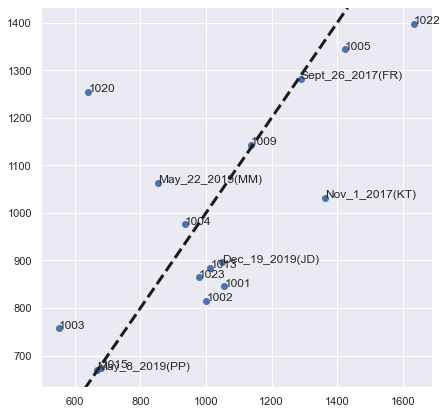

158.20565075460817
0.44447654129316916


In [145]:
### Linear Regression

paralist = [
#         'NET dose (mCi)', 
        'Weight (Kgs)',
#         "weight_-1",
#         'Age',
#         "Sex",
#         "Genotype",
        'lambda',
        'dose_by_age',
        'weight_by_age',
#         "asg",
    ]
error1, ytrue1, ypred1 = lou_model(new_df, paralist, mode="linear")
print(np.mean(error1))
print(r2_score(ytrue1, ypred1))

Leave-One-Out model predicting ...
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15] TEST: [13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15] TEST: [14]


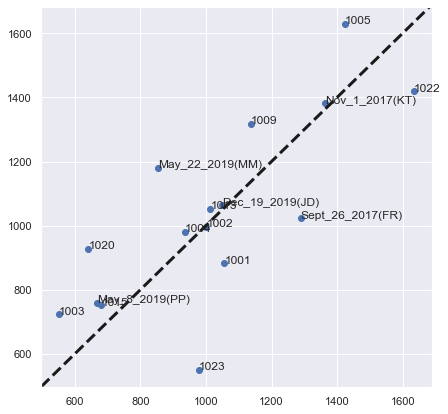

158.80409413577235
0.5352857621767206


In [146]:
### Gradient Boosting Regressor

paralist = [
#         'NET dose (mCi)', 
        'Weight (Kgs)',
#         "weight_-1",
        'Age',
#         "Sex",
#         "Genotype",
        'lambda',
#         'dose_by_age',
#         'weight_by_age',
#         "asg",
    ]


error2, ytrue2, ypred2 = lou_model(new_df, paralist, mode="gbr")
print(np.mean(error2))
print(r2_score(ytrue2, ypred2))

Leave-One-Out model predicting ...
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15] TEST: [13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15] TEST: [14]


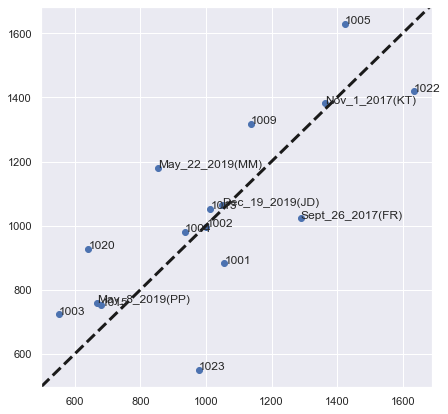

158.80409413577235
0.5352857621767206


In [567]:
### Gradient Boosting Regressor

paralist = [
#         'NET dose (mCi)', 
        'Weight (Kgs)',
#         "weight_-1",
        'Age',
#         "Sex",
#         "Genotype",
        'lambda',
#         'dose_by_age',
#         'weight_by_age',
#         "asg",
    ]


error2, ytrue2, ypred2 = lou_model(new_df, paralist, mode="gbr")
print(np.mean(error2))
print(r2_score(ytrue2, ypred2))

In [15]:
r2_score(ytrue2, ypred2)

NameError: name 'ytrue2' is not defined

In [147]:
[z[0] for z in ypred2]

[882.9486920204464,
 995.9572768878247,
 723.5573964400979,
 980.7107810273477,
 1628.795041216879,
 1318.5540261532456,
 1052.5033873935813,
 750.9783115214801,
 928.2789699153792,
 1418.7159119406176,
 549.4685620759061,
 1063.2195266848385,
 758.9271554841697,
 1180.6612103433165,
 1382.1928526481786,
 1023.4358245913614]

In [570]:
aif_simple.ID

0                 1001
1                 1002
2                 1003
3                 1004
4                 1005
5                 1009
6                 1013
7                 1015
8                 1020
9                 1022
10                1023
11     Dec_19_2019(JD)
12      May_8_2019(PP)
13     May_22_2019(MM)
14      Nov_1_2017(KT)
15    Sept_26_2017(FR)
Name: ID, dtype: object

In [496]:
r2_score(ytrue2, ypred2)

0.2881244618438479

In [497]:
r2_score(ytrue1, ypred1)

0.2477632905318664

In [513]:
error2

[173.23885147955355,
 5.425735022175331,
 171.663027640098,
 44.32385527734766,
 205.955007156879,
 181.2098237932455,
 38.76593854358134,
 69.79833481148012,
 286.9028160753792,
 216.54616492938248,
 429.934712624094,
 14.397307464838377,
 90.99249973416966,
 326.8485766033165,
 19.35445498817853,
 265.5084000286387]